In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from fastai.callbacks import *


from custom_nets import *

In [3]:
raw_image_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/raw_image/train/'

# image with skeleton base paths
im_skel_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/im+skeleton/train/'
skel_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/skeleton/train/'

# masked image base path
im_masked_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/maskRCNN_segmentation/masked/train/'

# dlib points-drawn image base paths
blank_dlib_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/dlib_images/dlib/train/'
im_dlib_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/dlib_images/im+dlib/train/'
skel_dlib_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/dlib_images/skel+dlib/train/'
im_skel_dlib_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/dlib_images/im+skel+dlib/train/'


# csv containing raw image names, yaw-pitch-roll, dlib points, skeleton image names, im+skeleton image names, and masked image names
all_images_YPR_dlib_csv_file_base_path = \
        '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/CSVs/with_test_set/train/'

In [4]:
# d = {3:'Hello', 5:'No'}
# d[3]

In [5]:
num_features_YPR = 3
num_features_DLIB = 136

class_names = ['selfie', 'non_selfie', 'mirror_selfie', 'non_mirror_selfie']

image_paths = {'im'             : [raw_image_base_path],               'skeleton'       : [skel_base_path],      'im_skeleton'     : [im_skel_base_path],      'im_masked'     : [im_masked_base_path],
               'im,YPR'         : [raw_image_base_path],               'im_skeleton,YPR': [im_skel_base_path],   'skeleton,YPR'    : [skel_base_path], 
               'im_dlib,YPR'    : [im_dlib_base_path],                 'skel_dlib,YPR'  : [skel_dlib_base_path], 'im_skel_dlib,YPR': [im_skel_dlib_base_path], 'blank_dlib,YPR': [blank_dlib_base_path],
               'im,skeleton,YPR': [raw_image_base_path, skel_base_path]}

custom_network_architectures = {'ImageTabularModel_YPR_res50'    : ImageTabularModel_YPR(num_features_YPR, [models.resnet50]),
                                'ImageTabularModel_YPR_dense201' : ImageTabularModel_YPR(num_features_YPR, [models.densenet201]) , 
                                'ImageTabularModel_YPR_dlib'     : ImageTabularModel_YPR(num_features_YPR + num_features_DLIB, [models.resnet34])
                               }

network_architectures = {'im'              : (models.resnet50, models.densenet201, models.vgg19_bn),
                         'im,YPR'          : (custom_network_architectures['ImageTabularModel_YPR_res50'],custom_network_architectures['ImageTabularModel_YPR_dense201']), 
                         'im_skeleton,YPR' : (custom_network_architectures['ImageTabularModel_YPR_res50'],custom_network_architectures['ImageTabularModel_YPR_dense201']),
                         'im_masked'       : (models.resnet50,),
                        }


network_architecture_names = { 'im'              : ('resnet50', 'densenet201', 'vgg19_bn'),
                               'im,YPR'          : ('ImageTabularModel_YPR',),
                               'im_skeleton,YPR' : ('ImageTabularModel_YPR_Resnet50','ImageTabularModel_YPR_Dense201'),
                               'im_masked'       : ('resnet50',),
                              }


class_configs = {'selfie__vs__no_selfie'                       : (('selfie',),('non_selfie',)), 
                 'selfie_mirror__vs__non_selfie_non_mirrror'   : (('selfie','mirror_selfie'),('non_selfie','non_mirror_selfie')), 
                 'mirror__vs__non_mirrror'                     : (('mirror_selfie',),('non_mirror_selfie',))}

feature_configs = {'im,skeleton,YPR'  : {'image_data':('im_name','skeleton'),  'num_data':['yaw','pitch','roll']},
                   'im'               : {'image_data':('im_name',),            'num_data':[]},
                   'skeleton'         : {'image_data':('skeleton',),           'num_data':[]},                   
                   'im_skeleton'      : {'image_data':('im_skeleton',),        'num_data':[]},
                   'im_masked'        : {'image_data':('im_masked',),          'num_data':[]},
                   'im,YPR'           : {'image_data':('im_name',),            'num_data':['yaw','pitch','roll']},
                   'im_skeleton,YPR'  : {'image_data':('im_skeleton',),        'num_data':['yaw','pitch','roll']},
                   'skeleton,YPR'     : {'image_data':('skeleton',),           'num_data':['yaw','pitch','roll']},                   
                   'im_dlib,YPR'      : {'image_data':('im_dlib',),            'num_data':['yaw','pitch','roll']},
                   'skel_dlib,YPR'    : {'image_data':('skel_dlib',),          'num_data':['yaw','pitch','roll']},
                   'im_skel_dlib,YPR' : {'image_data':('im_skel_dlib',),       'num_data':['yaw','pitch','roll']},
                   'blank_dlib,YPR'   : {'image_data':('dlib',),               'num_data':['yaw','pitch','roll']},
                  }


# feature          -> column name in DF
#---------------------------------------
# raw image        -> im_name
# skeleton only    -> skeleton
# image+skeleton   -> im_skeleton
# masked image     -> im_masked
# blank im+dlib    -> dlib
# raw image+dlib   -> im_dlib
# skeleton+dlib    -> skel_dlib
# im+sleleton+dlib -> im_skel_dlib
# yaw              -> yaw
# pitch            -> pitch
# roll             -> roll
# dlib pts         -> x_1, y_1, ... , x_68, y_68


# csv.columns

# Configuration

In [6]:
feature_config_label = 'im_skeleton,YPR'
#feature_config_label = 'im'
net_arch_idx = 1  # change index to select a different architecture/backbone 

class_config = class_configs['selfie__vs__no_selfie'] # 'selfie_vs_no_selfie' or 'selfie__mirror_vs_non_selfie___non_mirrror'
#class_config = class_configs['selfie_mirror__vs__non_selfie_non_mirrror']
#class_config = class_configs['mirror__vs__non_mirrror']
feature_config = feature_configs[feature_config_label]
network_architecture = network_architectures[feature_config_label][net_arch_idx] 
network_architecture_name = network_architecture_names[feature_config_label][net_arch_idx]

is_testing = False

# Load csvs into per-label dataframes

In [7]:
class_dataframes = {}

for class_name in class_names:
    csv = pd.read_csv(all_images_YPR_dlib_csv_file_base_path+class_name+'_with_testset.csv')
    #csv.insert(0, column = 'class_label',value = len(csv.index)*[f"{class_name}"])
    for i, im_feature_col in enumerate(feature_config['image_data']):        
        csv[f'path_{i:02d}'] = csv.class_label + '/' + csv[im_feature_col]
        #csv = csv.drop(['filename'], axis = 1)
    
    class_dataframes[class_name] = csv
        #print(csv.columns)
        #csv.head()

In [8]:
csv.head()

,class_label,im_name,x_min,y_min,x_max,y_max,confidence_score,yaw,pitch,roll,...,y_68,skeleton,im_skeleton,im_masked,dlib,im_dlib,skel_dlib,im_skel_dlib,is_test,path_00
0,non_mirror_selfie,21942668215_6e85ce854d_c.jpg,113.444016,57.137173,182.754196,132.164490,NaN,-36.658585,-17.108208,2.841003,...,82,21942668215_6e85ce854d_c.jpg_skeleton.jpg,21942668215_6e85ce854d_c.jpg_im_skeleton.jpg,21942668215_6e85ce854d_c.jpg_masked.jpg,21942668215_6e85ce854d_c_dlib_only.jpg,21942668215_6e85ce854d_c_dlib.jpg,21942668215_6e85ce854d_c.jpg_skeleton_dlib.jpg,21942668215_6e85ce854d_c.jpg_im_skeleton_dlib.jpg,0,non_mirror_selfie/21942668215_6e85ce854d_c.jpg...
1,non_mirror_selfie,google_faces__110618_000108.jpg,88.976105,53.586029,194.349915,180.566544,NaN,-12.694344,-15.782524,11.781647,...,112,google_faces__110618_000108.jpg_skeleton.jpg,google_faces__110618_000108.jpg_im_skeleton.jpg,google_faces__110618_000108.jpg_masked.jpg,google_faces__110618_000108_dlib_only.jpg,google_faces__110618_000108_dlib.jpg,google_faces__110618_000108.jpg_skeleton_dlib.jpg,google_faces__110618_000108.jpg_im_skeleton_dl...,0,non_mirror_selfie/google_faces__110618_000108....
2,non_mirror_selfie,google_medium_shot_face_010112_000538.jpg,103.273010,71.900574,181.120209,234.320435,NaN,7.867615,4.090118,8.581444,...,131,google_medium_shot_face_010112_000538.jpg_skel...,google_medium_shot_face_010112_000538.jpg_im_s...,google_medium_shot_face_010112_000538.jpg_mask...,google_medium_shot_face_010112_000538_dlib_onl...,google_medium_shot_face_010112_000538_dlib.jpg,google_medium_shot_face_010112_000538.jpg_skel...,google_medium_shot_face_010112_000538.jpg_im_s...,0,non_mirror_selfie/google_medium_shot_face_0101...
3,non_mirror_selfie,google_faces__251213_000068.jpg,130.480408,13.828512,170.518005,57.133636,NaN,-2.895096,-21.899353,-0.638931,...,39,google_faces__251213_000068.jpg_skeleton.jpg,google_faces__251213_000068.jpg_im_skeleton.jpg,google_faces__251213_000068.jpg_masked.jpg,google_faces__251213_000068_dlib_only.jpg,google_faces__251213_000068_dlib.jpg,google_faces__251213_000068.jpg_skeleton_dlib.jpg,google_faces__251213_000068.jpg_im_skeleton_dl...,1,non_mirror_selfie/google_faces__251213_000068....
4,non_mirror_selfie,24146502870_915723d44d_c.jpg,94.539200,51.739666,152.880386,164.739883,NaN,-28.479874,-12.382072,3.665863,...,100,24146502870_915723d44d_c.jpg_skeleton.jpg,24146502870_915723d44d_c.jpg_im_skeleton.jpg,24146502870_915723d44d_c.jpg_masked.jpg,24146502870_915723d44d_c_dlib_only.jpg,24146502870_915723d44d_c_dlib.jpg,24146502870_915723d44d_c.jpg_skeleton_dlib.jpg,24146502870_915723d44d_c.jpg_im_skeleton_dlib.jpg,1,non_mirror_selfie/24146502870_915723d44d_c.jpg...


In [9]:
[class_dataframe.shape for _, class_dataframe in class_dataframes.items()], class_dataframes.keys()

([(1216, 159), (1199, 159), (1171, 159), (1212, 159)],
 dict_keys(['selfie', 'non_selfie', 'mirror_selfie', 'non_mirror_selfie']))

In [10]:
class_config
class_01_labels = class_config[0]
class_02_labels = class_config[1]

class_01_labels, class_02_labels 

(('selfie',), ('non_selfie',))

In [11]:
# class_config[0]

In [12]:
class_01_df = class_dataframes[class_01_labels[0]]
for i,pos_class_label in enumerate(class_01_labels[1:]):
    class_01_df = class_01_df.append(class_dataframes[class_01_labels[i]])

class_01_df['class_label'] = class_01_labels[0]    
    
class_02_df = class_dataframes[class_02_labels[0]]    
for i,neg_class_label in enumerate(class_02_labels[1:]):
    class_02_df = class_02_df.append(class_dataframes[class_02_labels[i]])
        
class_02_df['class_label'] = class_02_labels[0]

#selfie_df = class_dataframes['selfie'].sample(n=len(class_dataframes['non_selfie'].index), replace=False, random_state=4, axis=0)

print(class_01_df.shape, class_02_df.shape)
print(set(class_01_df.class_label), set(class_02_df.class_label))
#newdf = class_dataframes['selfie'].copy().append(class_dataframes['non_selfie'])
all_class_df = class_01_df.append(class_02_df)

(1216, 159) (1199, 159)
{'selfie'} {'non_selfie'}


In [13]:
print(all_class_df.shape)
all_class_df.head()

(2415, 159)


,class_label,im_name,x_min,y_min,x_max,y_max,confidence_score,yaw,pitch,roll,...,y_68,skeleton,im_skeleton,im_masked,dlib,im_dlib,skel_dlib,im_skel_dlib,is_test,path_00
0,selfie,google_selfie_face_240614_000455.jpg,89.165497,30.651741,197.377838,229.067047,NaN,-5.471474,-10.517761,2.510727,...,137,google_selfie_face_240614_000455.jpg_skeleton.jpg,google_selfie_face_240614_000455.jpg_im_skelet...,google_selfie_face_240614_000455.jpg_masked.jpg,google_selfie_face_240614_000455_dlib_only.jpg,google_selfie_face_240614_000455_dlib.jpg,google_selfie_face_240614_000455.jpg_skeleton_...,google_selfie_face_240614_000455.jpg_im_skelet...,0,selfie/google_selfie_face_240614_000455.jpg_im...
1,selfie,selfie_mshah_0000260.jpg,80.503311,81.839630,205.567429,242.020813,NaN,-1.656120,-22.516785,-5.354843,...,158,selfie_mshah_0000260.jpg_skeleton.jpg,selfie_mshah_0000260.jpg_im_skeleton.jpg,selfie_mshah_0000260.jpg_masked.jpg,selfie_mshah_0000260_dlib_only.jpg,selfie_mshah_0000260_dlib.jpg,selfie_mshah_0000260.jpg_skeleton_dlib.jpg,selfie_mshah_0000260.jpg_im_skeleton_dlib.jpg,0,selfie/selfie_mshah_0000260.jpg_im_skeleton.jpg
2,selfie,google_selfie_face_221214_000342.jpg,99.930939,18.002396,225.676270,225.900085,NaN,-4.957504,9.064941,-0.161568,...,131,google_selfie_face_221214_000342.jpg_skeleton.jpg,google_selfie_face_221214_000342.jpg_im_skelet...,google_selfie_face_221214_000342.jpg_masked.jpg,google_selfie_face_221214_000342_dlib_only.jpg,google_selfie_face_221214_000342_dlib.jpg,google_selfie_face_221214_000342.jpg_skeleton_...,google_selfie_face_221214_000342.jpg_im_skelet...,1,selfie/google_selfie_face_221214_000342.jpg_im...
3,selfie,selfie_mshah_0003414.jpg,93.739922,49.757812,223.862854,229.142426,NaN,7.558365,-12.061974,3.384087,...,144,selfie_mshah_0003414.jpg_skeleton.jpg,selfie_mshah_0003414.jpg_im_skeleton.jpg,selfie_mshah_0003414.jpg_masked.jpg,selfie_mshah_0003414_dlib_only.jpg,selfie_mshah_0003414_dlib.jpg,selfie_mshah_0003414.jpg_skeleton_dlib.jpg,selfie_mshah_0003414.jpg_im_skeleton_dlib.jpg,1,selfie/selfie_mshah_0003414.jpg_im_skeleton.jpg
4,selfie,selfie_mshah_0019154.jpg,100.942413,5.262352,217.760498,154.478882,NaN,-0.130676,-6.205650,-0.251312,...,90,selfie_mshah_0019154.jpg_skeleton.jpg,selfie_mshah_0019154.jpg_im_skeleton.jpg,selfie_mshah_0019154.jpg_masked.jpg,selfie_mshah_0019154_dlib_only.jpg,selfie_mshah_0019154_dlib.jpg,selfie_mshah_0019154.jpg_skeleton_dlib.jpg,selfie_mshah_0019154.jpg_im_skeleton_dlib.jpg,0,selfie/selfie_mshah_0019154.jpg_im_skeleton.jpg


In [14]:
from training import *

all_class_df = all_class_df.reset_index(drop = True)

train_val_df = all_class_df[all_class_df['is_test']==0]
train_val_idxs = train_val_df.index.values

test_df = all_class_df[all_class_df['is_test']==1]
test_idxs = test_df.index.values

train_val_df = train_val_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [15]:
# # verify indices are computed correctly
# set(all_class_df.iloc[train_val_idxs].is_test.values), set(all_class_df.iloc[test_idxs].is_test.values)

train+val set size: 1947
test set size: 468
---------------------------------------------------------------------------------------
Using architecture: ImageTabularModel_YPR_Dense201
---------------------------------------------------------------------------------------
['/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/im+skeleton/train/selfie/google_selfie_face_240614_000455.jpg_im_skeleton.jpg'
 '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/im+skeleton/train/selfie/selfie_mshah_0000260.jpg_im_skeleton.jpg'
 '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/im+skeleton/train/selfie/google_selfie_face_221214_000342.jpg_im_skeleton.jpg'
 '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/im+skeleton/train/selfie/selfie_mshah_0003414.jpg_im_skeleton.jpg'
 ...
 '/disks/data/paper_projects/sel

---------------------------
type(x): <class 'list'>
x: [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), tensor([[ 0.1182,  0.4407, -0.0770],
        [-1.5435,  0.0082,  1.0581],
        [-0.0594, -0.0576, -0.1987],
        [-0.3093, -1.0034,  0.5161],
        [-1.5352, -0.9448,  0.5276],
        [-0.5304, -0.4896, -0.3808],
        [-0.6667,  0.2454,  0.0387],
        [-1.0796, -0.5421, -0.5248],
        [-1.5113, -1.1019,  1.6725],
        [ 1.0747, -0.5687, -0.9046],
        [-0.4671, -1.0901, -0.2401],
        [-0.8200, -0.4016, -0.6410],
        [-2.1545,  2.9870, -0.6412],
        [ 0.7114, -0.6358, -1.3776],
        [-0.1466,  0.3113,  0.5002],
        [-0.0303,  0.4374, -0.1528],
        [ 0.6429, -0.7293, -0.6695],
        [-0.0637, -0.0290,  0.1708],
        [-0.0199, -1.1405,  0.3004],
        [ 0.7324, -0.4080, -0.3704],
        [ 0.2745,  0.0905, -0.3538],
        [-3.1410,  0.5084, -1.3491],

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.351193,0.234677,0.079060,0.920940,00:29


---------------------------
type(x): <class 'list'>
x: [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), tensor([[ 2.1936,  1.4193,  1.0055],
        [-0.4969, -0.5317, -0.3123],
        [ 0.2179, -0.9399,  1.6376],
        [ 0.9776,  1.0184,  0.7545],
        [-0.6420, -0.7648,  1.3798],
        [-0.5174, -0.0559,  0.5100],
        [ 0.9973, -0.3363,  0.6561],
        [-0.5304, -0.4896, -0.3808],
        [ 0.5918,  0.6069, -0.3236],
        [-0.3093, -1.0034,  0.5161],
        [-0.5197,  1.3094,  0.4241],
        [ 1.1223, -0.1025,  2.3355],
        [-0.0210, -0.1126, -0.2739],
        [-1.0765,  0.8947,  0.9621],
        [ 0.5001, -1.2319,  1.0285],
        [-0.3514, -0.1435,  1.4511],
        [ 0.9970, -0.2316,  1.3906],
        [-0.0992, -3.0351,  0.3485],
        [-0.0070, -0.5496, -0.1216],
        [ 1.2931,  1.0500,  0.5169],
        [-0.2230, -0.2340,  0.6195],
        [ 0.0366, -0.5561, -0.0509],

---------------------------
type(x): <class 'list'>
x: [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), tensor([[ 0.3781,  0.2932,  0.0760],
        [-1.2744, -0.4469,  0.0027],
        [-0.1797,  0.2152, -0.6546],
        [-0.1010,  0.4580, -0.4167],
        [ 1.1488,  1.3939,  1.8731],
        [-0.5236, -0.1528,  0.8723],
        [ 2.3260,  0.1296, -0.6184],
        [-0.1525, -0.0071,  1.0513],
        [-1.3477, -0.1762, -1.1736],
        [ 2.6436,  0.4834,  0.4417],
        [ 0.4391, -0.8147,  0.4160],
        [-1.0765,  0.8947,  0.9621],
        [ 0.9973, -0.3363,  0.6561],
        [ 0.2874,  0.0851, -0.5225],
        [-0.9462,  0.5379, -0.6900],
        [-1.7111, -0.5596,  1.3602],
        [-0.3059,  0.9646, -2.2159],
        [ 0.2241,  0.1437, -0.2217],
        [ 0.2424, -1.4247, -0.0364],
        [ 0.5615,  0.9757,  0.9732],
        [ 0.8745,  1.3600,  0.0565],
        [ 0.4777,  1.1516,  0.7125],

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.179172,0.216566,0.072650,0.927350,00:27


---------------------------
type(x): <class 'list'>
x: [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), tensor([[ 4.3166e-01,  7.4036e-01, -3.0634e-01],
        [-1.2928e-01,  8.7537e-01, -1.1203e+00],
        [ 6.8348e-01, -1.1732e+00,  2.0013e+00],
        [ 1.6507e-02,  7.9006e-01, -1.3089e+00],
        [ 2.7969e+00, -8.1687e-01, -1.5701e-01],
        [-7.9889e-02, -2.8135e-03,  1.2579e+00],
        [-2.1545e+00,  2.9870e+00, -6.4121e-01],
        [ 7.0804e-01, -1.7216e+00, -1.6363e+00],
        [-6.6741e-02,  1.1503e+00, -1.8887e-01],
        [ 6.5334e-01, -4.8968e-01,  6.7094e-01],
        [ 5.2755e-01, -3.0572e-01,  6.9931e-01],
        [-9.3580e-02, -3.7920e-01, -1.9171e-01],
        [-1.7183e+00, -8.4889e-01, -6.1777e-01],
        [-5.9922e-01, -3.2906e+00,  2.4524e-01],
        [-3.0738e-01, -3.2056e-01,  8.4747e-02],
        [ 4.5354e-01,  5.9818e-02, -2.3192e-01],
        [ 8.3643e-01, -1.8127

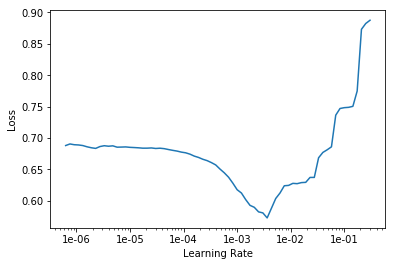

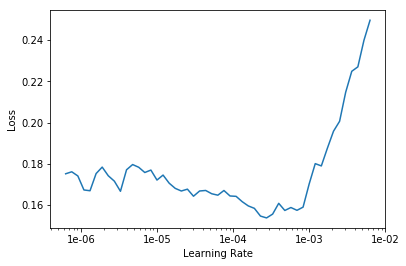

In [16]:
print("train+val set size:",len(train_val_df.index))
print("test set size:",len(test_df.index))


print('---------------------------------------------------------------------------------------')
print('Using architecture:', network_architecture_name)
print('---------------------------------------------------------------------------------------')

is_testing = True

if not is_testing:

    n_folds = 10

    skf = StratifiedKFold( n_splits = n_folds, shuffle=True, random_state=1)

    fold = 0
    learners = []

    for train_idxs, val_idxs in skf.split(train_val_df.index, train_val_df['class_label']):

        fold += 1

        print('======================================================')
        print(f'================= fold {fold} ===========================')

        savefile_suffix = '_CV_fold_{fold:02d}'
        if(len(feature_config['num_data'])>0): # Hybrid network
            learn = train_hybrid(train_idxs, val_idxs, train_val_df, image_paths, feature_config_label, feature_config, network_architecture, savefile_suffix )
        else:
            learn = train_cnn(train_idxs, val_idxs, train_val_df, image_paths, feature_config_label, feature_config, network_architecture, savefile_suffix )

        learners.append(learn)

        if(fold==1):
            break

else:
    
    learners = []
    savefile_suffix = 'test'
    if(len(feature_config['num_data'])>0): # Hybrid network
        learn = train_hybrid(train_val_idxs, test_idxs, all_class_df, image_paths, feature_config_label, feature_config, network_architecture, savefile_suffix, do_callbacks = not is_testing )
    else:
        learn = train_cnn(train_val_idxs, test_idxs, all_class_df, image_paths, feature_config_label, feature_config, network_architecture, savefile_suffix, do_callbacks = not is_testing )
    
    learners.append(learn)       
    

# results    

In [17]:
confusion_matrices = []
for learn in learners:
    interp = ClassificationInterpretation.from_learner(learn)
    
    confusion_mat = interp.confusion_matrix()
    confusion_matrices.append(confusion_mat)
    

for confusion_mat in confusion_matrices:
    #print(confusion_mat)
    print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))
    print('-----------------------------')
# plt.figure()
# interp.plot_confusion_matrix()

# confusion_mat = interp.confusion_matrix()
# print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))

[[0.91453  0.08547 ]
 [0.059829 0.940171]]
-----------------------------


In [18]:
# average per-class accuracy
summed_conf_mat = np.array(confusion_matrices).sum(axis=0).squeeze()
print('Accuracy matrix:\n',summed_conf_mat/np.sum(summed_conf_mat, axis = 1).reshape(-1,1))

#interp.plot_confusion_matrix()

Accuracy matrix:
 [[0.91453  0.08547 ]
 [0.059829 0.940171]]


In [19]:
doc(learn.show_results)

show_results [source] [test] show_results ( ds_type = <DatasetType.Valid: 2> , rows : int = 5 , ** kwargs ) 
 
 × No tests found for show_results . To contribute a test please refer to this guide and this discussion . Show rows result of predictions on ds_type dataset. 
 Show in docs

In [20]:
learn.show_results()

---------------------------
type(x): <class 'list'>
x: [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), tensor([[-0.3359,  1.8049, -0.0062],
        [ 0.3324, -0.4580,  0.2976],
        [ 1.5868,  0.6266,  2.0600],
        [-0.0319,  0.7872, -1.2013],
        [-0.5932, -0.9340, -0.9204],
        [-0.0468, -0.3463, -0.2688],
        [-0.4515, -0.7642,  2.7002],
        [-0.9018, -0.8459,  1.2536],
        [ 0.6432, -1.0129, -0.2823],
        [-0.0045,  0.4485, -0.3149],
        [ 1.6277, -1.0715, -0.9213],
        [ 0.7908,  1.0605,  2.4590],
        [ 1.8790, -0.5999, -0.4483],
        [-1.3409,  1.1884, -3.0430],
        [ 0.0968,  0.7011, -2.4741],
        [-0.6485,  0.3741, -0.1805],
        [-0.1029, -0.6292, -0.0364],
        [-1.1955,  0.7622, -0.6738],
        [ 0.4109, -0.1836,  0.0749],
        [ 0.0500, -0.1614,  1.8774],
        [ 0.0162, -0.7763, -1.4280],
        [ 0.2307,  0.4286,  0.6105],

AttributeError: 'MixedItem' object has no attribute 'reconstruct'

In [ ]:
# # results    
# confusion_matrices = []
# for learn in learners:
#     interp = ClassificationInterpretation.from_learner(learn)
#     interp.plot_confusion_matrix()

#     confusion_mat = interp.confusion_matrix()
#     confusion_matrices.append(confusion_mat)
#     print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))


# for confusion_mat in confusion_matrices:
#     print(confusion_mat)
#     print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))

# # plt.figure()
# # interp.plot_confusion_matrix()

# # confusion_mat = interp.confusion_matrix()
# # print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))

# # average per-class accuracy
# summed_conf_mat = np.array(confusion_matrices).sum(axis=0).squeeze()
# print(summed_conf_mat/np.sum(summed_conf_mat, axis = 1).reshape(-1,1))
    

# doc(interp.plot_top_losses)

In [21]:
# #interp = ClassificationInterpretation.from_learner(learn)
doc(interp.plot_top_losses)

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = None , heatmap_thresh : int = 16 , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

In [22]:
def _test_cnn_local(m):
#     if not isinstance(m, nn.Sequential) or not len(m) == 2: return False
#     return isinstance(m[1][0], (AdaptiveConcatPool2d, nn.AdaptiveAvgPool2d))
    return nn.AdaptiveAvgPool2d
# def _cl_int_plot_top_losses(self, k, largest=True, figsize=(12,12), heatmap:bool=None, heatmap_thresh:int=16,
#                             return_fig:bool=None)->Optional[plt.Figure]:
#     "Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class."
#     assert not heatmap or _test_cnn(self.learn.model), "`heatmap=True` requires a model like `cnn_learner` produces."
#     if heatmap is None: heatmap = _test_cnn(self.learn.model)
#     tl_val,tl_idx = self.top_losses(k, largest)
#     classes = self.data.classes
#     cols = math.ceil(math.sqrt(k))
#     rows = math.ceil(k/cols)
#     fig,axes = plt.subplots(rows, cols, figsize=figsize)
#     fig.suptitle('prediction/actual/loss/probability', weight='bold', size=14)
#     for i,idx in enumerate(tl_idx):
#         im,cl = self.data.dl(self.ds_type).dataset[idx]
#         cl = int(cl)
#         im.show(ax=axes.flat[i], title=
#             f'{classes[self.pred_class[idx]]}/{classes[cl]} / {self.losses[idx]:.2f} / {self.preds[idx][cl]:.2f}')
#         if heatmap:
#             xb,_ = self.data.one_item(im, detach=False, denorm=False)
#             m = self.learn.model.eval()
#             with hook_output(m[0]) as hook_a:
#                 with hook_output(m[0], grad= True) as hook_g:
#                     preds = m(xb)
#                     preds[0,cl].backward()
#             acts = hook_a.stored[0].cpu()
#             if (acts.shape[-1]*acts.shape[-2]) >= heatmap_thresh:
#                 grad = hook_g.stored[0][0].cpu()
#                 grad_chan = grad.mean(1).mean(1)
#                 mult = F.relu(((acts*grad_chan[...,None,None])).sum(0))
#                 sz = list(im.shape[-2:])
#                 axes.flat[i].imshow(mult, alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')                
#     if ifnone(return_fig, defaults.return_fig): return fig

In [24]:
im,cl = interp.data.dl(interp.ds_type).dataset[0]
im.obj[1].data

[tensor(0), tensor([-0.3359,  1.8049, -0.0062])]

<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>
<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>
printing heatmap
[tensor([0], device='cuda:0'), tensor([[ 1.0343,  0.8203, -0.8809]], device='cuda:0')]
---------------------------
type(x): <class 'list'>
x: [tensor([0], device='cuda:0'), tensor([[ 1.0343,  0.8203, -0.8809]], device='cuda:0')]

x[0] tensor([0], device='cuda:0')
x[0].shape torch.Size([1])
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
x[1] tensor([[ 1.0343,  0.8203, -0.8809]], device='cuda:0')
x[1].shape torch.Size([1, 3])
printing heatmap
[tensor([0], device='cuda:0'), tensor([[-0.0412,  0.2008, -0.1674]], device='cuda:0')]
---------------------------
type(x): <class 'list'>
x: [tensor([0], device='cuda:0'), tensor([[-0.0412,  0.2008, -0.1674]], device='cuda:0')]

x[0] tensor([0], device='cuda:0')
x[0].shape torch.Size([1])
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
x[1] tensor([[-0.0412,  0.2008, -0.1674]], device='cuda:0')
x[1].shape torch.Size([1, 3])
printing heatmap
[tensor([0], device

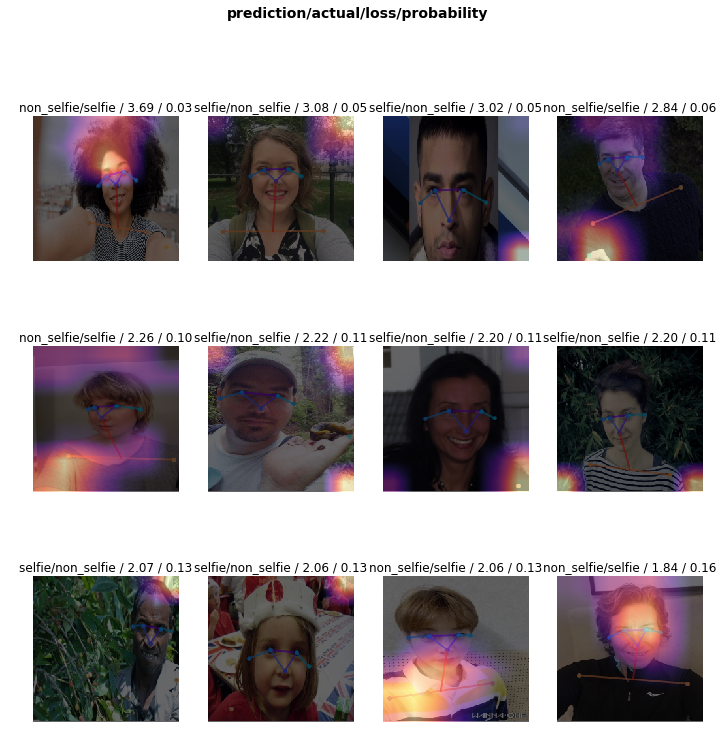

In [30]:
"""

self, k, largest=True, figsize=(12,12), heatmap:bool=False, heatmap_thresh:int=16,
                            return_fig:bool=None
"""
#from fastai.vision.learner import _test_cnn

k = 12
largest=True
figsize=(12,12)
heatmap_thresh=16
heatmap=None 

#assert not heatmap or _test_cnn(interp.learn.model), "`heatmap=True` requires a model like `cnn_learner` produces."
if heatmap is None: heatmap = _test_cnn_local(interp.learn.model)
print(heatmap)
tl_val,tl_idx = interp.top_losses(k, largest)
classes = interp.data.classes
cols = math.ceil(math.sqrt(k))
rows = math.ceil(k/cols)
fig,axes = plt.subplots(rows, cols, figsize=figsize)
fig.suptitle('prediction/actual/loss/probability', weight='bold', size=14)
print(heatmap)
for i,idx in enumerate(tl_idx):
    im,cl = interp.data.dl(interp.ds_type).dataset[idx]
    numeric = im.obj[1].data
    im_obj = im.obj[0]
    im = im.obj[0].data
    cl = int(cl)
    im_obj.show(ax=axes.flat[i], title=
        f'{classes[interp.pred_class[idx]]}/{classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    if heatmap:
        print('printing heatmap')
        #xb,_ = interp.data.one_item(im, detach=False, denorm=False)
        xb = im.unsqueeze(0).cuda()
        numeric = [x.unsqueeze(0).cuda() for x in numeric]
        m = interp.learn.model.eval()
        with hook_output(m.cnn[0]) as hook_a:
            with hook_output(m.cnn[0], grad= True) as hook_g:
                print(numeric)
                preds = m(xb, numeric)
                preds[0,cl].backward()
        acts = hook_a.stored[0].cpu()
        if (acts.shape[-1]*acts.shape[-2]) >= heatmap_thresh:
            grad = hook_g.stored[0][0].cpu()
            grad_chan = grad.mean(1).mean(1)
            mult = F.relu(((acts*grad_chan[...,None,None])).sum(0))
            sz = list(im.shape[-2:])
            axes.flat[i].imshow(mult, alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')                
#if ifnone(return_fig, defaults.return_fig): return fig

In [ ]:
interp.plot_top_losses(k=4)


In [ ]:
interp.plot_confusion_matrix()

In [ ]:
def get_ex(f): return open_image(f)

def plots_f(num_rows, num_cols, fig_height, fig_width,  files, titles = None, **kwargs):

    plt.tight_layout()
    print(len(files))
    plots = plt.subplots(num_rows,num_cols,figsize=(fig_width,fig_height))[1].flatten();

    if not titles:
        titles = len(files)*[""]
        use_gap = False
    else:
        use_gap = True
        
    #print(len(plt.subplots(
    #    num_rows,num_cols,figsize=(fig_width,fig_height))[1].flatten()))
    [get_ex(files[i]).show(ax=ax, title=titles[i]) for i,ax in enumerate(plots) if i < len(files)];
    [plot.axis('off') for plot in plots];    

    #fig,axes = plt.subplots(num_rows, num_cols, figsize=(fig_width,fig_height))        
    #[get_ex(files[i]).show(ax=axes.flat[i]) for i,ax in enumerate(axes)]

    if not use_gap:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=0, hspace=.2)
    plt.show()


    
# -----------------------------------------------------------------    
    
def plot_top_k(learn, interp, num_rows, num_cols, k, plot_config, inch_per_img = 2, show_title = False, do_print = True):

    """

    plot_config =  {'sort_by_most_to_least_confident' :  True or False if 'prediction_type' is not all, ignored otherwise
                    'prediction_type': 'all', # 'all', 'correct_only', or 'incorrect_only'
                    'true_label_filter_by': 'seffie' # None if 'prediction_type' is 'all' else one of the labels:str 
                   }

    """    
    
    sort_most2_least_conf = plot_config['sort_by_most_to_least_confident']
    prediction_type = plot_config['prediction_type']   
    true_label_filter_by = plot_config['true_label_filter_by']   
                

    # ----------------- sorted according to the order in present in the dataset
    all_class_labels = learn.data.classes
    
    predicted_probabilities = interp.preds.numpy()
    predicted_class_labels_int = interp.pred_class.numpy()
    predicted_class_labels_str = [all_class_labels[pred_label] for pred_label in predicted_class_labels_int]

    true_labels_int = np.array([all_class_labels.index(str(true_label)) for true_label in learn.data.valid_ds.y])
    true_labels_str = [str(true_label) for true_label in learn.data.valid_ds.y]
    
    
    if(len(learn.data.valid_dl.items) >0 and type(learn.data.valid_dl.items[0])==int):
        filenames = learn.data.valid_dl.item_lists[0].items # mixed item
    else:    
        filenames = learn.data.valid_ds.items    
    
    print(predicted_probabilities.shape)
    # ------------------------------------------------------------

    # retrieve descending-sorted losses and the corresponding data's indices 
    loss_vals_most2least, loss_vals_most2least_indices = interp.top_losses()
    
    loss_vals_most2least = loss_vals_most2least.numpy()
    loss_vals_most2least_indices = loss_vals_most2least_indices.numpy()

    print(loss_vals_most2least[1:5],loss_vals_most2least[-5:])

    # ----------------- sorted by largest to smallest loss
    
    true_labels_int_most2least = true_labels_int[loss_vals_most2least_indices]
    true_class_labels_str_most2least = [true_labels_str[i] for i in loss_vals_most2least_indices]
    
    predicted_class_labels_int_most2least = predicted_class_labels_int[loss_vals_most2least_indices]
    predicted_class_labels_str_most2least = [predicted_class_labels_str[i] for i in loss_vals_most2least_indices]
    predicted_probabilities_most2least = predicted_probabilities[loss_vals_most2least_indices,:] 
    
    filenames_most2least = [filenames[i] for i in loss_vals_most2least_indices]
    
    #print(predicted_probabilities_most2least.shape)
    
    # ----------------sorted by most to least loss, filtered by correctly classified, incorrectly classified, or unfiltered
     
    correctly_classified_indices_most2least = np.arange(len(loss_vals_most2least_indices))[true_labels_int_most2least==predicted_class_labels_int_most2least]
    incorrectly_classified_indices_most2least = np.arange(len(loss_vals_most2least_indices))[true_labels_int_most2least!=predicted_class_labels_int_most2least]
    all_indices_most2least = np.arange(len(loss_vals_most2least_indices))

    #print(len(correctly_classified_indices_most2least), len(incorrectly_classified_indices_most2least))
    #print(correctly_classified_indices_most2least)
    
     

    if prediction_type=='all':
        type_indices = all_indices_most2least
    elif prediction_type=='correct_only':    
        type_indices = correctly_classified_indices_most2least
    elif prediction_type=='incorrect_only':    
        type_indices = incorrectly_classified_indices_most2least
        
    true_class_labels_str_selected = [true_class_labels_str_most2least[i] for i in type_indices]
    true_labels_int_selected = true_labels_int_most2least[type_indices]    
    predicted_class_labels_int_selected = predicted_class_labels_int_most2least[type_indices]
    predicted_class_labels_str_selected = [predicted_class_labels_str_most2least[i] for i in type_indices]
    predicted_probabilities_selected = predicted_probabilities_most2least[type_indices,:]     
    filenames_selected = [filenames_most2least[i] for i in type_indices]
    
    
    
    if prediction_type!='all':    
        if(true_label_filter_by!='all'):
            class_filtered_indices = np.arange(len(true_labels_int_selected))[true_labels_int_selected==all_class_labels.index(true_label_filter_by)]
            indices = class_filtered_indices
            print(len(indices))
        else:
            indices = np.arange(len(true_class_labels_str_selected))
        
    else:
        indices = np.arange(len(true_class_labels_str_selected))
                                           

    if prediction_type!='all':
        if(prediction_type=='correct_only'):
            if sort_most2_least_conf: 
                indices = np.flip(indices)
        elif prediction_type=='incorrect_only':
            if not sort_most2_least_conf: 
                indices = np.flip(indices)    
                                           
    true_class_labels_str_selected_for_class = [true_class_labels_str_selected[i] for i in indices]
    true_labels_int_selected_for_class = true_labels_int_selected[indices]    
    predicted_class_labels_int_selected_for_class = predicted_class_labels_int_selected[indices]
    predicted_class_labels_str_selected_for_class = [predicted_class_labels_str_selected[i] for i in indices]
    predicted_probabilities_selected_for_class = predicted_probabilities_selected[indices,:]     
    filenames_selected_for_class = [filenames_selected[i] for i in indices]
                           
#     #print(true_class_labels_str_correctly_classified, len(true_class_labels_str_correctly_classified))
    #print(true_labels_int_most2least_correctly_classified)
    
    true_class_labels_str_final = true_class_labels_str_selected_for_class
    true_labels_int_final = true_labels_int_selected_for_class   
    predicted_class_labels_int_final = predicted_class_labels_int_selected_for_class
    predicted_class_labels_str_final = predicted_class_labels_str_selected_for_class
    predicted_probabilities_final = predicted_probabilities_selected_for_class   
    filenames_selected_final = filenames_selected_for_class
    
    
    k = min(k, len(filenames_selected_final))
        
    print()
    for idx in range( k ):
        print("index:",idx+1)

        predicted_class_label_str = predicted_class_labels_str_final[idx]
        predicted_probability = predicted_probabilities_final[idx][true_labels_int_final[idx]]
        true_label_str = true_class_labels_str_final[idx]
        im_filename = filenames_selected_final[idx]

        print(im_filename)
        print("predicted class:", predicted_class_label_str.upper(), 
              f"\npredicted probability for actual class [{true_label_str.upper()}]:{predicted_probability:.2f}", 
              #"\nactual class :",str(true_label) 
             )
        print()
        
        
    if(show_title):
        titles = [ f"{predicted_class_labels_str_most2least[i]}/{true_class_labels_str_most2least[i]}/{loss_vals_most2least[i]:.2f}/"+
              f"prob[{all_class_labels[0]}]={predicted_probabilities_most2least[i,0]:.2f}/prob[{all_class_labels[1]}]={predicted_probabilities_most2least[i,1]:.2f}," for i in range(k)]
    else:
        titles = None
    
    plots_f(num_rows, num_cols, inch_per_img*num_rows,inch_per_img*num_cols,  filenames_selected_final[:k], titles) 

#     print(correctly_classified_indices_most2least)
#     print(incorrectly_classified_indices_most2least)

    return






classes = learn.data.classes
classes = {i:i for i in classes}
print("All classes:", classes)

plot_configs =  [{'sort_by_most_to_least_confident' :  True, # True or False
                'prediction_type': 'correct_only', # 'all', 'correct_only', or 'incorrect_only'
                'true_label_filter_by': classes['selfie'] # None if 'prediction_type' is 'all' else either 'all' or one of the labels:str 
               }
               ]

num_rows = 2
num_cols = 3
k = num_rows*num_cols

plot_top_k(learn, interp, num_rows, num_cols, k, plot_configs[0], inch_per_img = 2, show_title = False, do_print = True)










In [ ]:
# learn.data.valid_ds.__dict__

# learn.save('/disks/data/paper_projects//selfie_detection/scripts/Experiments/With_Cross_Validation/Dense_im_skeleton_YPR.pkl')

In [ ]:
# open_image('/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/raw_image/train/selfie/selfie_mshah_0014311.jpg')

In [ ]:
# doc(MixedItem)
#learn.export('/disks/data/paper_projects/selfie_detection/scripts/Experiments/With_Cross_Validation/1.Selfie_vs_NonSelfie/1.Image_Only/im_dense201.pkl')
learn.data.valid_ds.x.items

In [ ]:
# #loss, acc = learn.validate()
# #print(acc)
#learn.TTA()
# len(data.train_ds)
type(learn.data.valid_ds)

In [ ]:
len(learn.data.valid_ds.items),learn.data.valid_ds.y[0]

In [ ]:
import matplotlib.gridspec as gridspec

def get_ex(f): return open_image(f)

def plots_f(rows, cols, width, height, files, **kwargs):
    plt.tight_layout()
    [get_ex(files[i]).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
    plt.subplots_adjust(wspace=0, hspace=0)
    
plots_f(2, 4, 11.5, 6, learn.data.valid_ds.items[indices[:8]])    

# data.classes

In [ ]:
# # K-fold cross validation

# image_paths[feature_config_label][0]

# train_val_df.head()

In [ ]:
# import fastai
# fastai.utils.show_install(1)

In [ ]:
# learn.save('/disks/data/paper_projects/selfie_detection/scripts/Experiments/With_Cross_Validation/1.Selfie_vs_NonSelfie/1.Image_Only/im_dense201.pkl')

In [ ]:
# item, labels = next(iter(data.train_dl))

In [ ]:
# # item[1][0], item[1][1]
# mixed.train.x.item_lists[1].get_emb_szs()

In [ ]:
# print(*imagenet_stats)

In [ ]:
# emb = mixed.train.x.item_lists[1].get_emb_szs()

In [ ]:
# from fastai.torch_core import *
# from fastai.vision import *
# from fastai.tabular.models import *
# from fastai.tabular import *
# from fastai.layers import *
# import torch

# class ImageTabularModel(nn.Module):
#     "Basic model for tabular data."
#     def __init__(self, emb_szs:ListSizes, n_cont:int, layers:Collection[int], ps:Collection[float]=None):
#         super().__init__()
#         self.cnn = create_body(models.resnet34)
#         self.tab = TabularModel({}, n_cont, 128, [512, 356]) #TabularModel(emb_szs, n_cont, 512, layers, ps)

#         self.reduce = nn.Sequential(*([Flatten()] + bn_drop_lin((512*7*7), 512, bn=True, p=0.5, actn=nn.ReLU(inplace=True))))
#         self.merge = nn.Sequential(*bn_drop_lin(512 + 512, 1024, bn=True, p=0.5, actn=nn.ReLU(inplace=True)))
#         self.final = nn.Sequential(*bn_drop_lin(1024, 2, bn=True, p=0., actn=nn.ReLU(inplace=True)))

#     def forward(self, img:Tensor, x_cat:Tensor, x_cont:Tensor) -> Tensor:
#         imgLatent = self.reduce(self.cnn(img))
#         tabLatent = self.tab(x_cat, x_cont)

#         cat = torch.cat(imgLatent, tabLatent)

#         return self.final(self.merge(cat))

In [ ]:
# class ImageTabularTextModel(nn.Module):
#     def __init__(self, n_cont:int):
#         super().__init__()
#         self.cnn = create_body(models.resnet34)
#         nf = num_features_model(self.cnn) * 2
#         drop = .5

#         self.tab = TabularModel({}, n_cont, 128, [512, 256])

#         self.reduce = nn.Sequential(*([AdaptiveConcatPool2d(), Flatten()] + bn_drop_lin(nf, 512, bn=True, p=drop, actn=nn.ReLU(inplace=True))))
#         self.merge = nn.Sequential(*bn_drop_lin(512 + 128, 128, bn=True, p=drop, actn=nn.ReLU(inplace=True)))
#         self.final = nn.Sequential(*bn_drop_lin(128, 2, bn=False, p=0., actn=None))
#         #self.final = nn.Sequential(*bn_drop_lin(512, 2, bn=False, p=0., actn=None))
#         #print(self)
        
#     def forward(self, img:Tensor, x:Tensor) -> Tensor:
#         #print(img.shape)        
#         imgCnn = self.cnn(img)
#         #print(imgCnn.shape)
#         imgLatent = self.reduce(imgCnn)
#         #print(imgLatent.shape)
#         tabLatent = self.tab(x[0], x[1])
#         #print(tabLatent.shape)
        
#         cat = torch.cat([imgLatent, F.relu(tabLatent)], dim=1)
#         #print(cat.shape)
        
#         pred = self.final(self.merge(cat))
#         #pred = torch.sigmoid(pred)  # making sure this is in the range 0-4
#         #pred = torch.sigmoid(self.final(self.reduce(imgCnn)))
#         #print(pred)
#         return pred #torch.softmax(torxh.zeros(1,2))
        
#     def reset(self):
#         for c in self.children():
#             if hasattr(c, 'reset'): c.reset()

In [ ]:
#     def _normalize_images_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor)->Tuple[Tensor,Tensor]:
#         "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
#         x,y = b
#         mean,std = mean.to(x[0].device),std.to(x[0].device)
#         x[0] = normalize(x[0],mean,std)
#         return x,y

#     def normalize_custom_funcs(mean:FloatTensor, std:FloatTensor, do_x:bool=True, do_y:bool=False)->Tuple[Callable,Callable]:
#         "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`."
#         mean,std = tensor(mean),tensor(std)
#         return (partial(_normalize_images_batch, mean=mean, std=std),
#                 partial(denormalize, mean=mean, std=std))

#     # doc(MixedItemList)
#     #image_paths[feature_config_label][used_cnn_idx]

#     max_allowed_backbones = 1
    
#     imgLists = []
#     for i in range(max_allowed_backbones):
#         imgLists.append(ImageList.from_df(all_class_df, path = image_paths[feature_config_label][i], cols=f'path_{i:02d}'))

#     tabList = TabularList.from_df(all_class_df, cat_names=[], cont_names = feature_config['num_data'], procs=[Normalize])
    
#     mixed = MixedItemList([imgLists[0], tabList], image_paths[feature_config_label][i], inner_df=imgLists[0].inner_df)\
#     .split_by_rand_pct(.2)\
#     .label_from_df(cols='class_label')
#     #.transform([[get_transforms()[0], []], [get_transforms()[1], []]], size=224)

#     data = mixed.databunch(no_check=True, bs=64, num_workers=0) # num_workers=0 here just to get errors more quickly
#     norm, denorm = normalize_custom_funcs(*imagenet_stats)
#     data.add_tfm(norm) # normalize images
    
#     def split_layers(model:nn.Module) -> List[nn.Module]:
#         groups = [[model.cnn]]
#         groups += [[model.tab, model.reduce, model.merge, model.final]]
#         return groups

#     class ImageTabularLearner(Learner):
#         def __init__(self, data:DataBunch, model:nn.Module, alpha:float=2., beta:float=1., **learn_kwargs):
#             super().__init__(data, model, **learn_kwargs)
#             self.split(split_layers)

#     # it = iter(data.valid_dl)
#     # for item, label in it:
#     #     print(label)        

#     model = network_architecture#ImageTabularTextModel(3)
#     learn = ImageTabularLearner(data, model, metrics=[error_rate])

#     learn.lr_find()
#     learn.recorder.plot()
#     learn.fit_one_cycle(10, .4e-3)
#     learn.save('resnet34_stage_1_im_sk_ypr')

#     # learn.fit_one_cycle(5, .7e-3)
#     learn.load('resnet34_stage_1_im_sk_ypr');
#     learn.unfreeze()
#     learn.lr_find()
#     learn.recorder.plot()
#     learn.fit_one_cycle(10, max_lr=slice(1.1e-6,1.1e-6/3))
#     interp = ClassificationInterpretation.from_learner(learn)
#     interp.plot_confusion_matrix()
#     confusion_mat = interp.confusion_matrix()
#     print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))
#     len(data.train_ds), len(data.valid_ds)    